In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
from astropy.visualization import quantity_support
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7fe9ca232310>

In [2]:
%config InlineBackend.figure_format = "retina"

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 18

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

# Load the data from Eric's file

In [6]:
df = pd.read_csv("../data/firas_monopole_spec_v1.txt", skiprows=18, delim_whitespace=True,
                 names=["freq", "intensity", "residual", "uncertainty", "poles_model"])

firas_freq = (df["freq"].values * u.cm**(-1) * const.c).to(u.GHz)
firas_int = df["intensity"].values * u.MJy / u.sr
firas_unc = df["uncertainty"].values * u.kJy / u.sr

# Define the blackbody function

In [7]:
def planck(nu, T, mu=0):
    return (2 * const.h * nu**3 / const.c**2 / (np.exp((const.h * nu - mu) / (const.k_B * T)) - 1)).to(u.MJy) / u.sr

# Plot the data with a 2.725K blackbody

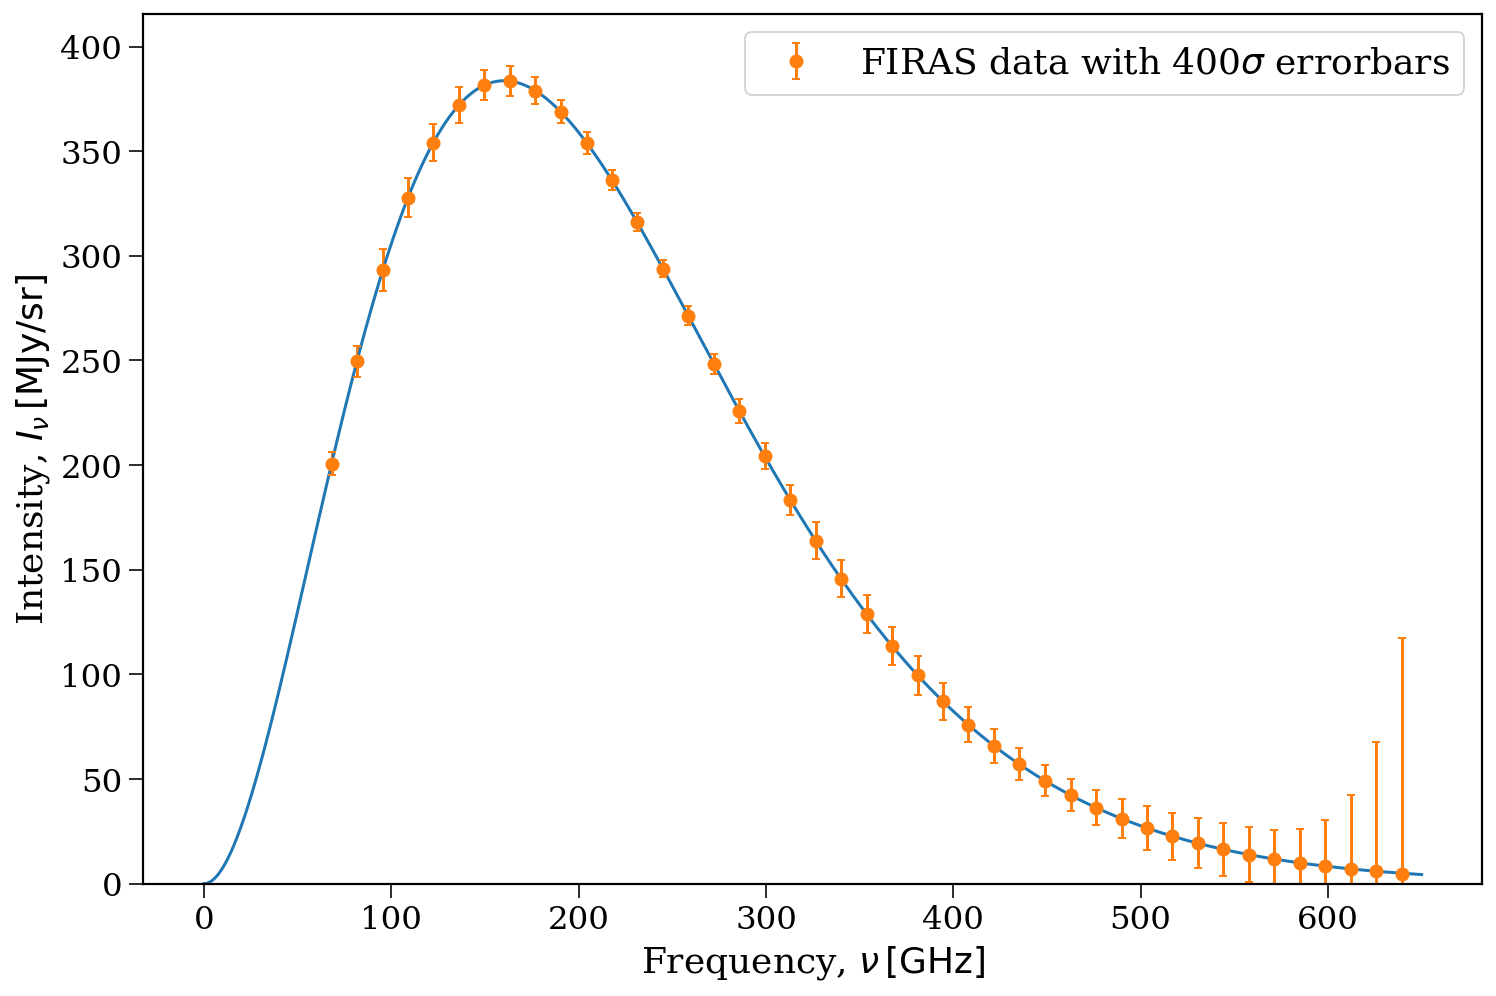

In [8]:
fig, ax = plt.subplots()

nu_range = np.linspace(0.01, 650, 1000) * u.GHz
ax.plot(nu_range, planck(nu_range, 2.725 * u.K))

ax.errorbar(firas_freq, firas_int, yerr=firas_unc * 400,
            marker="o", capsize=2, ls="none", label=r"FIRAS data with 400$\sigma$ errorbars")

ax.legend()

ax.set_xlabel(r"Frequency, $\nu \, [\rm GHz]$")
ax.set_ylabel(r"Intensity, $I_\nu \, [\rm MJy / sr]$")

ax.set_ylim(bottom=0)

plt.show()

# Calculate Chi Squared for a grid

In [9]:
def chisquare(freq, measured, uncertainty, T=2.2725 * u.K, mu = 0 * u.erg):
    model = planck(freq, T=T, mu=mu)
    return np.sum( (measured - model)**2 / uncertainty**2 ).decompose().value

In [10]:
%%time

T_range = np.linspace(2.72492, 2.72507, 200) * u.K
mu_range = np.linspace(0, 4e-20, 201) * u.erg

c2_grid = np.zeros((len(T_range), len(mu_range)))

for i in range(len(T_range)):
    for j in range(len(mu_range)):
        c2_grid[i][j] = chisquare(firas_freq, firas_int, firas_unc, T=T_range[i], mu=mu_range[j])

CPU times: user 25.6 s, sys: 298 ms, total: 25.9 s
Wall time: 25.7 s


# Find the maximum mu with 3 sig

In [11]:
T, MU = np.meshgrid(T_range, mu_range)

In [23]:
max_mu = MU.T[c2_grid <= c2_grid.min() + 6.63].max()
(max_mu / (const.k_B * 2.2725 * u.K)).decompose()

<Quantity 0.00011283>

# Plot up the results

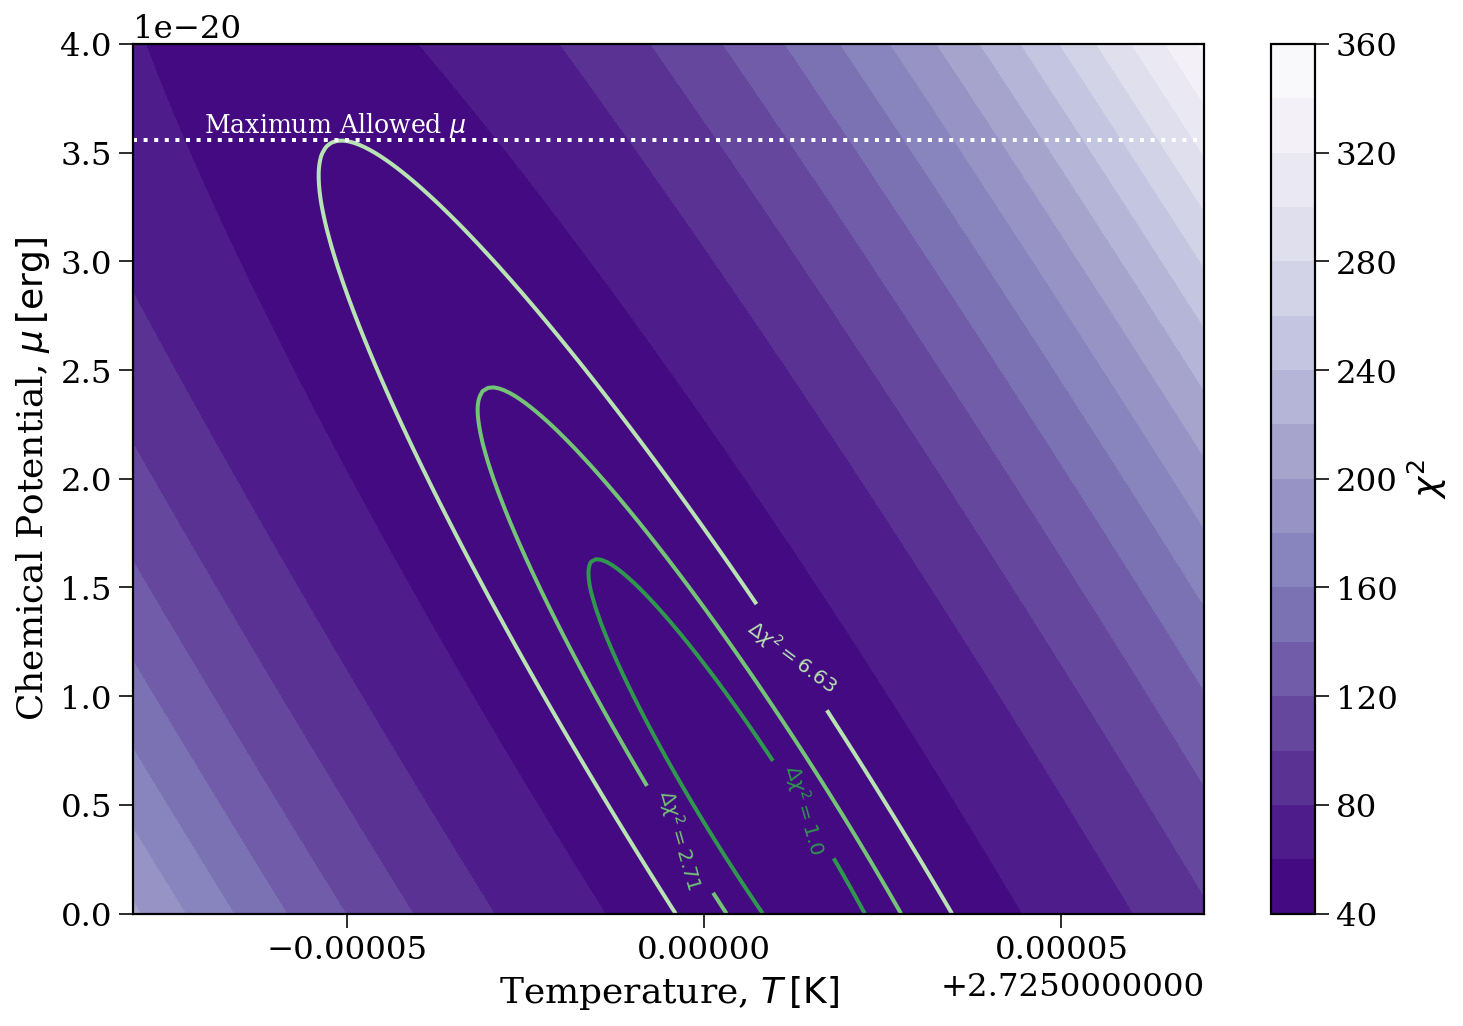

In [17]:
def fmt(x):
    return r"$\Delta \chi^2 = {{{}}}$".format(np.round(x - c2_grid.min(), 2))

fig, ax = plt.subplots()

greens = plt.get_cmap("Greens")
cont = ax.contourf(T_range, mu_range, c2_grid.T, cmap="Purples_r", levels=15)

conf = ax.contour(T_range, mu_range, c2_grid.T, levels=np.array([1, 2.71, 6.63]) + c2_grid.min(),
                  colors=[greens(0.7), greens(0.5), greens(0.3)], linewidths=2)

cbar = fig.colorbar(cont, ax=ax, label=r"$\chi^2$")

ax.set_xlabel(r"Temperature, $T \, [\rm K]$")
ax.set_ylabel(r"Chemical Potential, $\mu \, [\rm erg]$")

# ax.set_xticks([2.7249, 2.72495, 2.725, 2.72505, 2.7251])
ax.set_xticks([2.72495, 2.725, 2.72505])

ax.axhline(3.56e-20, lw=2, color="white", linestyle="dotted")
ax.annotate(r"Maximum Allowed $\mu$", xy=(2.72493, 3.56e-20), va="bottom", color="white", fontsize=0.7 * fs)

ax.clabel(conf, fmt=fmt, use_clabeltext=True)

plt.savefig("../figures/max_mu.pdf", format="pdf", bbox_inches="tight")

plt.show()